# Vorticity maps for all experiments

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import cartopy.mpl.ticker as cticker
import matplotlib.cm as mpl_cm
import matplotlib.colors as mcolors

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34837,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:40053,Total threads: 4
Dashboard: /proxy/38065/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:46723,


In [3]:
start_time, end_time = '2001-01-01', '2010-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
ρ0 = 1035

var_name = 'beta_v'
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

In [4]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_names = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
             'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
             'Monthly_mean_BVB_MOM6-SIS2_RYF_control', 
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt = ['mom6-om4-025-RYF-negativeNAO-2.0', 
        'mom6-om4-025-RYF-negativeNAO-1.0', 
        'mom6-om4-025-RYF-control', 
        'mom6-om4-025-RYF-positiveNAO-1.0',
        'mom6-om4-025-RYF-positiveNAO-2.0']

db = '/g/data/hh5/tmp/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

In [5]:
x_min_subtropics, x_max_subtropics = -100, 0
y_min_subtropics, y_max_subtropics = 10, 52
x_min_subpolar, x_max_subpolar = -70, -8
y_min_subpolar, y_max_subpolar = 40, 67

In [6]:
var_list = ['beta_v', 'BPT', 'curl_NL', 'curl_taus', 'curl_taub', 'curl_diff', 'mass_flux', 'curl_dudt', 'eta_dt']
var_list_labels = ['a. Planetary vorticity advection', 'b. Bottom pressure torque', 'c. Non-linear advection curl', 'd. Wind stress curl', 'e. Bottom drag curl', 'f. Viscosity curl', 'g. Mass flux', 'h. Vorticity tendency', 'i. Surface elevation tendency']
var_list_labels2 = ['Bottom pressure torque', 'Non-linear advection curl', 'Wind stress curl', 'Bottom drag curl', 'Viscosity curl', 'Mass flux', 'Velocity tendency', 'Surface elevation tendency', 'Residual']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred'] 

In [7]:
def BVB_variables(dir_name, var_number):
    v1 = xr.open_dataset(base_dir + dir_name + '/141-180/' + var_list[var_number] + '_filtered2.nc').__xarray_dataarray_variable__.sel(time = slice('2071-01-01', '2080-12-31'))
    v2 = xr.open_dataset(base_dir + dir_name + '/181-200/' + var_list[var_number] + '_filtered.nc').__xarray_dataarray_variable__
    variable = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(filter_scale = 2)
    return variable

def BVB_variables_test(dir_name, var_number):
    v1 = xr.open_dataset(base_dir + dir_name + '/181-200/' + var_list[var_number] + '_filtered.nc').__xarray_dataarray_variable__
    variable = v1.sel(time = slice('2100-01-01', '2100-12-31')).mean('time').sel(filter_scale = 2).sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
    return variable

In [8]:
vmin = np.array([-1e-9, -1e-9, -1e-9, -4e-10, -4e-10, -4e-10, -1e-10, -1e-10, -1e-10])
vmax = np.array([ 1e-9,  1e-9,  1e-9,  4e-10,  4e-10,  4e-10,  1e-10,  1e-10,  1e-10])

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
3
4
0
1
2
3
4
0
1
2
3
4


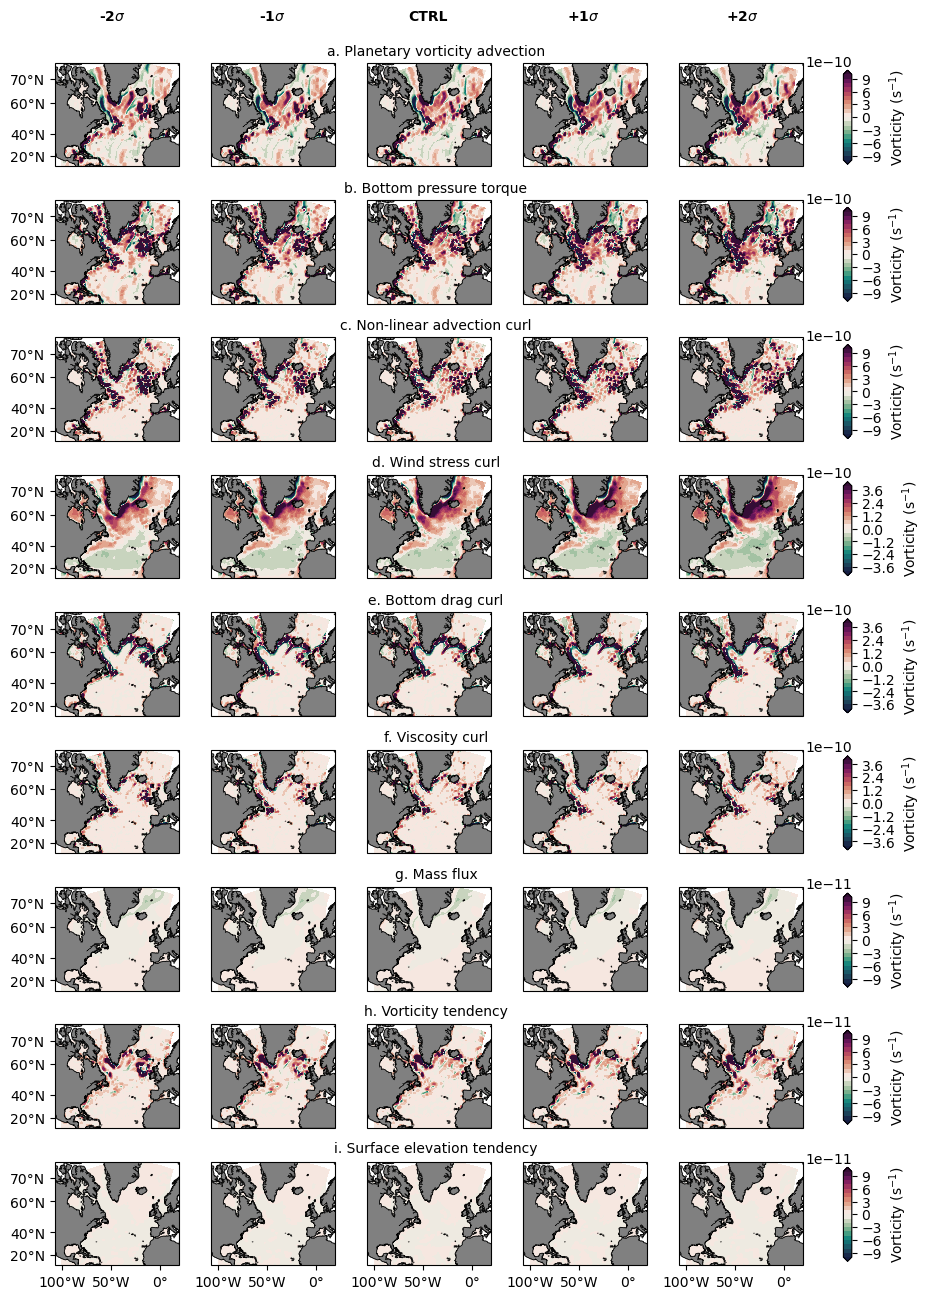

In [9]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 9, ncols = 5, figsize = (6 * 1.4, 9.6 * 1.4), subplot_kw = {'projection': projection})

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.25)

for j in range(9):
    for i in range(5):
        print(i)
        v1 = xr.open_dataset(base_dir + dir_names[i] + '/141-180/' + var_list[j] + '_filtered2.nc').__xarray_dataarray_variable__.sel(time = slice('2071-01-01', '2080-12-31')).sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
        v2 = xr.open_dataset(base_dir + dir_names[i] + '/181-200/' + var_list[j] + '_filtered.nc').__xarray_dataarray_variable__.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
        variable = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(filter_scale = 2)
        variable.load()
        p1 = axes[j][i].contourf(variable.geolon_c, variable.geolat_c, variable, levels = np.linspace(vmin[j], vmax[j], 21), 
                           cmap = cm.cm.curl, transform = ccrs.PlateCarree(), extend = 'both')
        axes[j][i].coastlines(resolution = '50m')
        axes[j][i].add_feature(land_50m)

    # Add colorbar
    cax = plt.axes([1.01, 1 - 0.094 - (j + 0.5) / 9.8, 0.01, 0.07])
    cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
    cb.ax.set_ylabel('Vorticity (s$^{-1}$)', fontsize = 10)

my_xticks = [-100, -50, 0]
my_yticks = [20, 40, 60, 70]

for i in range(5):
    axes[8][i].set_xticks(my_xticks, crs = ccrs.PlateCarree())
    axes[8][i].xaxis.set_major_formatter(cticker.LongitudeFormatter())

for i in range(9):
    axes[i][0].set_yticks(my_yticks, crs = ccrs.PlateCarree())
    axes[i][0].yaxis.set_major_formatter(cticker.LatitudeFormatter())

for row_idx, title in enumerate(var_list_labels):
    # Add row title
    fig.text(0.525, 1 - 0.01 - (row_idx + 0.5) / 9.8, title, ha = 'center', va = 'center', fontsize = 10)
    
fig.text(0.14, 0.965, expt_labels[0], ha = 'center', va = 'center', fontsize = 10, fontweight = 'bold')
fig.text(0.33, 0.965, expt_labels[1], ha = 'center', va = 'center', fontsize = 10, fontweight = 'bold')
fig.text(0.515, 0.965, expt_labels[2], ha = 'center', va = 'center', fontsize = 10, fontweight = 'bold')
fig.text(0.7, 0.965, expt_labels[3], ha = 'center', va = 'center', fontsize = 10, fontweight = 'bold')
fig.text(0.89, 0.965, expt_labels[4], ha = 'center', va = 'center', fontsize = 10, fontweight = 'bold')
plt.tight_layout(rect=[0, 0, 0.98, 0.95])  # Adjust layout

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Vorticity_maps_all3.jpg', bbox_inches = 'tight', 
            dpi = 300, transparent=True)